In [2]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import nltk
import re
import spacy
import gensim

import time
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')

### preprocessed from v0.2

In [ ]:
#from nltk.corpus import reuters, stopwords

#start_time = time.time()

#each file is pre-labeled for train (~73%) and test (remaining 27%)
#train_files = list(filter(lambda x: x.startswith('training'), reuters.fileids()))
#test_files = list(filter(lambda x: x.startswith('test'), reuters.fileids()))

#def text_cleaner(text):
#    text = re.sub(r'--',' ', text) #double hyphens cause problems
#    text = re.sub('[^A-Za-z0-9]+', ' ', text) #matches characters that are not letters or numbers
#    text = re.sub(r'\d+','', text) #this handles digits
    
    #comparison operators format weird
#    text = re.sub(r'&lt;', ' ', text)
#    text = re.sub(r'&gt;', ' ', text)
#    text = re.sub(r'&le;', ' ', text)
#    text = re.sub(r'&ge;', ' ', text)
    
    #lowercase and join
#    text = text.lower()
#    text = ' '.join(text.split())
#    return text

#populate train df
#train_df = pd.DataFrame()
#for file in train_files:
#    if len(reuters.categories(file)) == 1:
#        train_df = train_df.append({
#            'category':''.join(reuters.categories(file)),
#            'fileid':file,
#            'article':text_cleaner(reuters.raw([file]))}, ignore_index=True)

#populate test df
#test_df = pd.DataFrame()
#for file in test_files:
#    if len(reuters.categories(file)) == 1:
#        test_df = test_df.append({
#            'category':''.join(reuters.categories(file)),
#            'fileid':file,
#            'article':text_cleaner(reuters.raw(file))}, ignore_index=True)

#df = pd.concat([train_df, test_df], 0).reset_index(drop=True)
#print('this should print true: {}'.format(
#    len(df) == len(train_df) + len(test_df)))
#print('cell runtime: {:0.7} seconds'.format(time.time() - start_time))
#df.to_csv('preprocessed_df.csv', index=False)

In [3]:
df = pd.read_csv('preprocessed_df.csv')
df[:5]

,article,category,fileid
0,bahia cocoa review showers continued throughou...,cocoa,training/1
1,computer terminal systems lt cpml completes sa...,acq,training/10
2,n z trading bank deposit growth rises slightly...,money-supply,training/100
3,national amusements again ups viacom lt via bi...,acq,training/1000
4,rogers lt rog sees st qtr net up significantly...,earn,training/10000


### split classes & train/test

In [4]:
from sklearn.model_selection import train_test_split

df_earn = df.loc[df['category'] == 'earn']
df_acq = df.loc[df['category'] == 'acq']
df_crude = df.loc[df['category'] == 'crude']
df_trade = df.loc[df['category'] == 'trade']
df_money = df.loc[df['category'] == 'money-fx']

#set data/target for classes
X_train_earn, X_test_earn, y_train_earn, y_test_earn = train_test_split(
    df_earn['article'], df_earn['category'], test_size=0.25)

X_train_acq, X_test_acq, y_train_acq, y_test_acq = train_test_split(
    df_acq['article'], df_acq['category'], test_size=0.25)

X_train_crude, X_test_crude, y_train_crude, y_test_crude = train_test_split(
    df_crude['article'], df_crude['category'], test_size=0.25)

X_train_trade, X_test_trade, y_train_trade, y_test_trade = train_test_split(
    df_trade['article'], df_trade['category'], test_size=0.25)

X_train_money, X_test_money, y_train_money, y_test_money = train_test_split(
    df_money['article'], df_money['category'], test_size=0.25)

#earn vs acq
X_train = pd.concat([X_train_earn, X_train_acq], 0).reset_index(drop=True)
X_test = pd.concat([X_test_earn, X_test_acq], 0).reset_index(drop=True)
y_train = pd.concat([y_train_earn, y_train_acq], 0).reset_index(drop=True)
y_test = pd.concat([y_test_earn, y_test_acq], 0).reset_index(drop=True)

#crude vs trade vs money
X_train_ = pd.concat([X_train_crude, X_train_trade, X_train_money],
                     0).reset_index(drop=True)
X_test_ = pd.concat([X_test_crude, X_test_trade, X_test_money],
                     0).reset_index(drop=True)
y_train_ = pd.concat([y_train_crude, y_train_trade, y_train_money],
                     0).reset_index(drop=True)
y_test_ = pd.concat([y_test_crude, y_test_trade, y_test_money],
                     0).reset_index(drop=True)

### spacey parsing, word2vec token vectorization

In [ ]:
stop 

In [5]:
from collections import Counter
start_time = time.time()
#parser
nlp = spacy.load('en')

#load pre trained google model
model = gensim.models.KeyedVectors.load_word2vec_format(
    './GoogleNews-vectors-negative300.bin', binary=True)

print(time.time() - start_time)

58.87105584144592


In [174]:
#zeros = np.zeros([300,], dtype=list)
start_time = time.time()
train_nlp_subset = pd.concat([df_earn, df_acq], 0).reset_index(drop=True)
#train_nlp_subset = train_nlp_subset[:1]
#a = np.arange(300).reshape(300,)

for i, article in enumerate(train_nlp_subset['article']):
    #parse article
    article_nlp = nlp(article)
    #filter stopwords, punctuation
    article = [token.lemma_ for token in article_nlp 
                if not token.is_punct and not token.is_stop]
    #bag 20 most common words
    bag = ([item[0] for item in Counter(article).most_common(20)])
    #add new words as features and populate rows with word vector
    #df_temp = pd.DataFrame()
    for word in bag:
        if word not in train_nlp_subset.columns and word in model.wv.vocab.keys():
            train_nlp_subset[word] = ''
            train_nlp_subset.loc[i, word] = np.mean([model.wv[word]])
            #train_nlp_subset[word] = [zeros]
            #train_nlp_subset.loc[i, word] = model.wv[word]
train_nlp_subset.replace('', np.mean(np.zeros(300,)), inplace=True)
print(time.time() - start_time)

9413.554196119308


In [183]:
train_nlp_subset.to_csv('train_nlp_subset.csv', index=False)

In [158]:
#train_nlp_subset.replace('', np.mean(np.zeros(300,)), inplace=True)

In [ ]:
#np.array([
#            np.mean([self.word2vec[w] for w in words if w in self.word2vec] 
#                    or [np.zeros(self.dim)], axis=0)
#            for words in X

In [175]:
X = train_nlp_subset.loc[:, ~train_nlp_subset.columns.isin(['article', 'category', 'fileid'])]
y = train_nlp_subset['category']

In [176]:
from sklearn.preprocessing import normalize, Normalizer
from sklearn.decomposition import TruncatedSVD
X_norm = normalize(X)
X_svd = TruncatedSVD(2).fit_transform(X_norm)

n_clust = 2

In [177]:
from sklearn.model_selection import cross_val_score
import xgboost as xgb
xgbc = xgb.XGBClassifier().fit(X_svd, y)

print('vanilla xgboost classifier')
print('train 10 cv mean: {}'.format(cross_val_score(xgbc, X, y, cv=10)))

vanilla xgboost classifier
train 10 cv mean: [0.63081862 0.63081862 0.6318328  0.63123994 0.63123994 0.63123994
 0.63123994 0.63123994 0.63123994 0.63123994]


Text(0.5,1,'train rbf ari: -0.0027907041526651325')

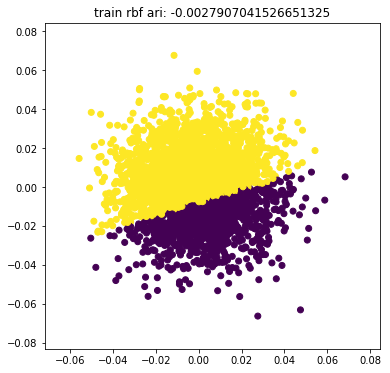

In [178]:
from sklearn.cluster import SpectralClustering
from sklearn.metrics import adjusted_rand_score

#rbf
sc_rbf = SpectralClustering(n_clusters=n_clust,
                            affinity='rbf').fit(X_svd)

predict_rbf_train = sc_rbf.fit_predict(X_svd)
#plots
plt.figure(figsize=(6,6))
#plt.suptitle('affinity=rbf')
#plt.subplot(121)
plt.scatter(X_svd[:,0], X_svd[:,1], c=predict_rbf_train)
plt.title('train rbf ari: {}'.format(adjusted_rand_score(
    y, predict_rbf_train)))

In [184]:
train_nlp = pd.read_csv('train_nlp_subset.csv')

In [185]:
train_nlp[:10]

,article,category,fileid,quarter,roger,say,significantly,earning,dlrs,year,...,reportedly,apollo,pneumo,mailing,fw,brik,tc,max,cental,traf
0,rogers lt rog sees st qtr net up significantly...,earn,training/10000,0.000476,-0.02157,-0.009143,-0.016079,-0.00708,-0.010891,0.00181,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,island telephone share split approved lt islan...,earn,training/10002,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,questech inc lt qtec year net shr loss nil vs ...,earn,training/10008,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,shoe town inc lt shu year ended jan three shr ...,earn,training/10023,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,american nursery products lt ansy rd qtr net p...,earn,training/10027,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,national fsi inc lt nfsi th qtr loss shr loss ...,earn,training/1003,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,discus corp lt disc th qtr loss shr loss six c...,earn,training/10032,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,entertainment publications sees cts shr rd qtr...,earn,training/10035,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,pay n pak stores inc lt pnp th qtr feb net shr...,earn,training/10037,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,american nursery products lt ansy rd qtr net q...,earn,training/10040,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
